In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
%xmode Minimal

Exception reporting mode: Minimal


In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
#import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray.air import session, Checkpoint
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer

from ray.data.datasource import SimpleTorchDatasource
from ray.data.preprocessors import Concatenator, Chain, StandardScaler

from ray import tune
from ray.tune .tuner import Tuner, TuneConfig
from ray.air.config import RunConfig

import matplotlib.pyplot as plt

from ray_cluster_control import start_ray_cluster, stop_ray_cluster

In [4]:
start_ray_cluster()

RayCluster "octo-next-eje" has started
Access your cluster dashboard at http://ray-dashboard-octo-next-eje-open-data-hub.apps.et-gpu.zfq7.p1.openshiftapps.com


In [5]:
ray.init('ray://{ray_head}-ray-head:10001'.format(ray_head=os.environ['RAY_CLUSTER_NAME']))

Python version:,3.8.12
Ray version:,2.0.0
Dashboard:,http://10.131.2.239:8265


In [6]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [7]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [8]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [9]:
len(pet_data)

3680

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cpu


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


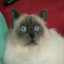

label:6


In [11]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [12]:
def ConvNet():
    return nn.Sequential(
        nn.Conv2d(3, 16, 3, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 3,1 ),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(6272 , 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 37)
    )

In [13]:
net = ConvNet()
net.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=37, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.655046
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.604965
Finished Training


In [17]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

In [18]:
# Now with Ray 

In [19]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

(_execute_read_task pid=334) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz to data/oxford-iiit-pet/images.tar.gz


100%|██████████| 791918971/791918971 [00:42<00:00, 18808683.87it/s]


(_execute_read_task pid=334) Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet
(_execute_read_task pid=334) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz to data/oxford-iiit-pet/annotations.tar.gz


 90%|█████████ | 17301504/19173078 [00:01<00:00, 18934385.06it/s]


(_execute_read_task pid=334) Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 13795056.75it/s]


In [20]:
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.5, shuffle=True)

Shuffle Map:   0%|          | 0/1 [00:00<?, ?it/s]

(map pid=178, ip=10.128.4.70) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz to data/oxford-iiit-pet/images.tar.gz


100%|██████████| 791918971/791918971 [00:41<00:00, 19112499.75it/s]


(map pid=178, ip=10.128.4.70) Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet
(map pid=178, ip=10.128.4.70) Downloading https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz to data/oxford-iiit-pet/annotations.tar.gz


 83%|████████▎ | 15826944/19173078 [00:01<00:00, 17343329.77it/s]


(map pid=178, ip=10.128.4.70) Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


Shuffle Reduce: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


In [21]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [22]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss = loss_fn(pred, y).item()  
    
    return test_loss
            

In [23]:
def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]
    
    
    train_dataloader = train.get_dataset_shard("train")
    test_dataloader = train.get_dataset_shard("test")
    model = ConvNet()
    model = train.torch.prepare_model(model).to("cuda")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        loss_results.append(loss)
        eval_results.append(val_loss)
        session.report({"loss":loss},)
    
    session.report({"loss":loss, "model": model,
                   "training_loss": loss_results,"eval_loss": eval_results},
                   checkpoint=Checkpoint.from_dict(dict(epoch=epoch, model=model.state_dict())))
            
    

In [24]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config = {
    "batch_size": 4,
    "epochs": 100,
    "momentum": 0.9,
    "lr": 0.001,
    "tune_run": False    
        
    },
    scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = True,
    trainer_resources = {"CPU":1}),
    run_config = RunConfig(
        name = "test_run",
        local_dir = "./",
        sync_config = tune.SyncConfig(syncer=None)),
    datasets = {"train": train_dataset,
               "test":valid_dataset},
    )

In [25]:
result = trainer.fit()

(TunerInternal pid=2131) == Status ==
(TunerInternal pid=2131) Current time: 2022-10-21 15:25:56 (running for 00:00:03.33)
(TunerInternal pid=2131) Memory usage on this node: 5.8/30.9 GiB
(TunerInternal pid=2131) Using FIFO scheduling algorithm.
(TunerInternal pid=2131) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=2131) Result logdir: /home/ray/test_run
(TunerInternal pid=2131) Number of trials: 1/1 (1 RUNNING)
(TunerInternal pid=2131) +--------------------------+----------+-------------------+
(TunerInternal pid=2131) | Trial name               | status   | loc               |
(TunerInternal pid=2131) |--------------------------+----------+-------------------|
(TunerInternal pid=2131) | TorchTrainer_a693c_00000 | RUNNING  | 10.131.2.239:2188 |
(TunerInternal pid=2131) +--------------------------+----------+-------------------+
(TunerInternal pid=2131) 
(TunerInternal pid=2131) 


(RayTrainWorker pid=2222) 2022-10-21 15:25:58,917	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=2222) 2022-10-21 15:25:59,144	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=2131) == Status ==
(TunerInternal pid=2131) Current time: 2022-10-21 15:26:01 (running for 00:00:08.33)
(TunerInternal pid=2131) Memory usage on this node: 7.6/30.9 GiB
(TunerInternal pid=2131) Using FIFO scheduling algorithm.
(TunerInternal pid=2131) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=2131) Result logdir: /home/ray/test_run
(TunerInternal pid=2131) Number of trials: 1/1 (1 RUNNING)
(TunerInternal pid=2131) +--------------------------+----------+-------------------+
(TunerInternal pid=2131) | Trial name               | status   | loc               |
(TunerInternal pid=2131) |--------------------------+----------+-------------------|
(TunerInternal pid=2131) | TorchTrainer_a693c_00000 | RUNNING  | 10.131.2.239:2188 |
(TunerInternal pid=2131) +--------------------------+----------+-------------------+
(TunerInternal pid=2131) 
(TunerInternal pid=2131) 
(TunerInternal pid=2131) Result for TorchTrainer_a

(TunerInternal pid=2131) 2022-10-21 15:27:07,236	INFO tune.py:758 -- Total run time: 74.03 seconds (73.64 seconds for the tuning loop).
2022-10-21 15:27:07,932	ERROR checkpoint_manager.py:133 -- The requested checkpoint is not available on this node, most likely because you are using Ray client or disabled checkpoint synchronization. To avoid this, enable checkpoint synchronization to cloud storage by specifying a `SyncConfig`. The checkpoint may be available on a different node - please check this location on worker nodes: /home/ray/test_run/TorchTrainer_a693c_00000_0_2022-10-21_15-25-53/checkpoint_000000


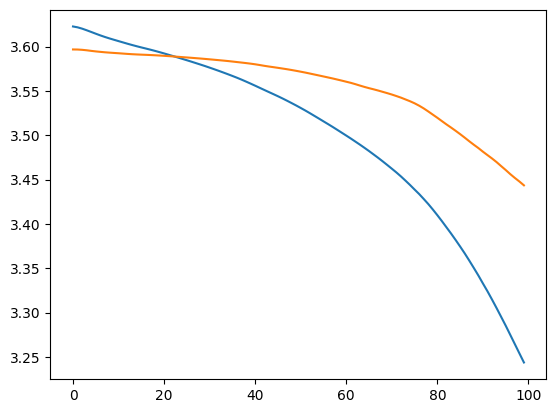

In [27]:
plt.plot(result.metrics["training_loss"])
plt.plot(result.metrics["eval_loss"])
plt.show()

In [29]:
model = result.metrics['model']
model_scripted = torch.jit.script(model)
model_scripted.save("models/trained_model.pt")

In [30]:
# Tune! 

In [31]:
# Define a search space.
search_space = {"train_loop_config": 
    {"lr": tune.grid_search([0.001, 0.1]),
    "momentum": tune.grid_search([0.1, 0.9]),
    "batch_size": tune.grid_search([4]), 
    "epochs": tune.grid_search([300]),
    "tune_run": tune.grid_search([True])}
}

metric = "loss"

In [32]:
tuner = Tuner(trainer,
              param_space=search_space,
              tune_config=TuneConfig(num_samples=1, metric=metric, mode="min"),
             )

In [33]:
result_grid = tuner.fit()

(TunerInternal pid=3234) == Status ==
(TunerInternal pid=3234) Current time: 2022-10-21 16:37:02 (running for 00:00:02.77)
(TunerInternal pid=3234) Memory usage on this node: 5.8/30.9 GiB
(TunerInternal pid=3234) Using FIFO scheduling algorithm.
(TunerInternal pid=3234) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=3234) Result logdir: /home/ray/test_run
(TunerInternal pid=3234) Number of trials: 4/4 (3 PENDING, 1 RUNNING)
(TunerInternal pid=3234) +--------------------------+----------+-----------------+------------------------+------------------------+------------------------+------------------------+------------------------+
(TunerInternal pid=3234) | Trial name               | status   | loc             |   train_loop_config... |   train_loop_config... |   train_loop_config/lr |   train_loop_config... | train_loop_config...   |
(TunerInternal pid=3234) |--------------------------+----------+-----------------+------------------

(RayTrainWorker pid=244, ip=10.128.4.70) 2022-10-21 16:37:04,879	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=244, ip=10.128.4.70) 2022-10-21 16:37:05,067	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=3234) == Status ==
(TunerInternal pid=3234) Current time: 2022-10-21 16:37:07 (running for 00:00:07.78)
(TunerInternal pid=3234) Memory usage on this node: 6.1/30.9 GiB
(TunerInternal pid=3234) Using FIFO scheduling algorithm.
(TunerInternal pid=3234) Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=3234) Result logdir: /home/ray/test_run
(TunerInternal pid=3234) Number of trials: 4/4 (2 PENDING, 2 RUNNING)
(TunerInternal pid=3234) +--------------------------+----------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
(TunerInternal pid=3234) | Trial name               | status   | loc               |   train_loop_config... |   train_loop_config... |   train_loop_config/lr |   train_loop_config... | train_loop_config...   |
(TunerInternal pid=3234) |--------------------------+----------+-------------------+------------

(RayTrainWorker pid=3336) 2022-10-21 16:37:07,638	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=3336) 2022-10-21 16:37:07,829	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=3234) Result for TorchTrainer_959ff_00000:
(TunerInternal pid=3234)   _time_this_iter_s: 3.7898480892181396
(TunerInternal pid=3234)   _timestamp: 1666370228
(TunerInternal pid=3234)   _training_iteration: 1
(TunerInternal pid=3234)   date: 2022-10-21_16-37-08
(TunerInternal pid=3234)   done: false
(TunerInternal pid=3234)   experiment_id: 13a9140d1abe4aabaeda92dcc8eb612f
(TunerInternal pid=3234)   hostname: octo-next-eje-ray-cluster-example-worker-xqqcf
(TunerInternal pid=3234)   iterations_since_restore: 1
(TunerInternal pid=3234)   loss: 3.5953614711761475
(TunerInternal pid=3234)   node_ip: 10.128.4.70
(TunerInternal pid=3234)   pid: 213
(TunerInternal pid=3234)   time_since_restore: 6.318845272064209
(TunerInternal pid=3234)   time_this_iter_s: 6.318845272064209
(TunerInternal pid=3234)   time_total_s: 6.318845272064209
(TunerInternal pid=3234)   timestamp: 1666370228
(TunerInternal pid=3234)   timesteps_since_restore: 0
(TunerInternal pid=3234)   training_itera

(RayTrainWorker pid=234, ip=10.128.2.74) 2022-10-21 16:37:25,600	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=234, ip=10.129.4.218) 2022-10-21 16:37:25,750	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=234, ip=10.128.2.74) 2022-10-21 16:37:25,773	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0
(RayTrainWorker pid=234, ip=10.129.4.218) 2022-10-21 16:37:25,933	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=3234) Result for TorchTrainer_959ff_00001:
(TunerInternal pid=3234)   _time_this_iter_s: 0.6668877601623535
(TunerInternal pid=3234)   _timestamp: 1666370247
(TunerInternal pid=3234)   _training_iteration: 22
(TunerInternal pid=3234)   date: 2022-10-21_16-37-27
(TunerInternal pid=3234)   done: false
(TunerInternal pid=3234)   experiment_id: a7aa286c85cb46a7b07903e029b4f86f
(TunerInternal pid=3234)   hostname: octo-next-eje-ray-cluster-octo-next-eje-head-4zdvg
(TunerInternal pid=3234)   iterations_since_restore: 22
(TunerInternal pid=3234)   loss: 3.0292367935180664
(TunerInternal pid=3234)   node_ip: 10.131.2.239
(TunerInternal pid=3234)   pid: 3300
(TunerInternal pid=3234)   time_since_restore: 22.316624641418457
(TunerInternal pid=3234)   time_this_iter_s: 0.6666357517242432
(TunerInternal pid=3234)   time_total_s: 22.316624641418457
(TunerInternal pid=3234)   timestamp: 1666370247
(TunerInternal pid=3234)   timesteps_since_restore: 0
(TunerInternal pid=3234)   tra

(TunerInternal pid=3234) NaN or Inf found in input tensor.
(TunerInternal pid=3234) NaN or Inf found in input tensor.


(TunerInternal pid=3234) Result for TorchTrainer_959ff_00003:
(TunerInternal pid=3234)   _time_this_iter_s: 0.007835149765014648
(TunerInternal pid=3234)   _timestamp: 1666370419
(TunerInternal pid=3234)   _training_iteration: 301
(TunerInternal pid=3234)   date: 2022-10-21_16-40-19
(TunerInternal pid=3234)   done: true
(TunerInternal pid=3234)   eval_loss: [3.6102116107940674, 3.57818341255188, 3.5612926483154297, 3.476954698562622,
(TunerInternal pid=3234)     3.470672845840454, 3.3174149990081787, 3.3911848068237305, 3.4579379558563232, 3.621151924133301,
(TunerInternal pid=3234)     3.449187994003296, 3.5792338848114014, 3.814288854598999, 3.8319480419158936, 4.1375837326049805,
(TunerInternal pid=3234)     4.247939586639404, 6.084779262542725, 5.5567450523376465, 4.893978118896484, 6.578577041625977,
(TunerInternal pid=3234)     13.378326416015625, .nan, .nan, .nan, .nan, .nan, .nan, .nan, .nan, .nan, .nan,
(TunerInternal pid=3234)     .nan, .nan, .nan, .nan, .nan, .nan, .nan, .na

(RayTrainWorker pid=244, ip=10.128.4.70) E1021 16:40:25.501742310     269 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(TunerInternal pid=3234) Result for TorchTrainer_959ff_00002:
(TunerInternal pid=3234)   _time_this_iter_s: 0.6524245738983154
(TunerInternal pid=3234)   _timestamp: 1666370425
(TunerInternal pid=3234)   _training_iteration: 265
(TunerInternal pid=3234)   date: 2022-10-21_16-40-25
(TunerInternal pid=3234)   done: false
(TunerInternal pid=3234)   experiment_id: f0f3d09d6cd2441d9691bf615e009229
(TunerInternal pid=3234)   hostname: octo-next-eje-ray-cluster-example-worker-kkqhv
(TunerInternal pid=3234)   iterations_since_restore: 265
(TunerInternal pid=3234)   loss: 0.5792755484580994
(TunerInternal pid=3234)   node_ip: 10.128.2.74
(TunerInternal pid=3234)   pid: 203
(TunerInternal pid=3234)   time_since_restore: 182.19568610191345
(TunerInternal pid=3234)   time_this_iter_s: 0.6526153087615967
(TunerInternal pid=3234)   time_total_s: 182.19568610191345
(TunerInternal pid=3234)   timestamp: 1666370425
(TunerInternal pid=3234)   timesteps_since_restore: 0
(TunerInternal pid=3234)   trainin

(RayTrainWorker pid=3336) E1021 16:40:57.462303904    3364 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(TunerInternal pid=3234) == Status ==
(TunerInternal pid=3234) Current time: 2022-10-21 16:40:58 (running for 00:03:58.55)
(TunerInternal pid=3234) Memory usage on this node: 8.2/30.9 GiB
(TunerInternal pid=3234) Using FIFO scheduling algorithm.
(TunerInternal pid=3234) Resources requested: 0/4 CPUs, 0/4 GPUs, 0.0/16.8 GiB heap, 0.0/7.01 GiB objects
(TunerInternal pid=3234) Current best trial: 959ff_00001 with loss=2.3659247744944878e-05 and parameters={'train_loop_config': {'lr': 0.1, 'momentum': 0.1, 'batch_size': 4, 'epochs': 300, 'tune_run': True}}
(TunerInternal pid=3234) Result logdir: /home/ray/test_run
(TunerInternal pid=3234) Number of trials: 4/4 (4 TERMINATED)
(TunerInternal pid=3234) +--------------------------+------------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------+--------+------------------+---------------+--------------+---------------------+
(TunerInternal pid=3234) | 

(TunerInternal pid=3234) 2022-10-21 16:40:58,411	INFO tune.py:758 -- Total run time: 238.68 seconds (237.78 seconds for the tuning loop).


In [34]:
best_result = result_grid.get_best_result()
best_model = best_result.metrics["model"]
model_scripted = torch.jit.script(best_model)
model_scripted.save('models/best_model_scripted.pt')

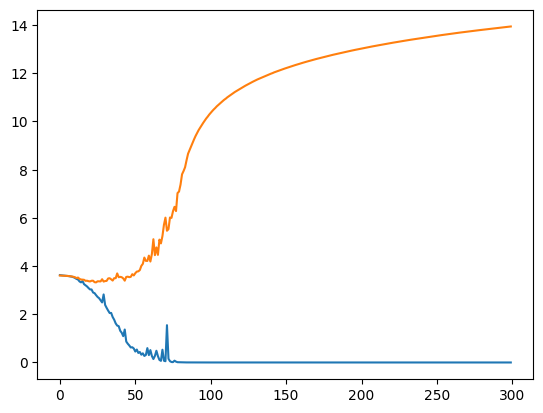

In [35]:
plt.plot(best_result.metrics["training_loss"])
plt.plot(best_result.metrics["eval_loss"])
plt.show()

In [36]:
model = torch.jit.load("models/best_model_scripted.pt") 
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=MaxPool2d)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=MaxPool2d)
  (4): RecursiveScriptModule(original_name=Flatten)
  (5): RecursiveScriptModule(original_name=Linear)
  (6): RecursiveScriptModule(original_name=ReLU)
  (7): RecursiveScriptModule(original_name=Linear)
  (8): RecursiveScriptModule(original_name=ReLU)
  (9): RecursiveScriptModule(original_name=Linear)
)

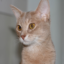

label:0
prediction: 0


In [37]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [38]:
X = []
y = []
y_pred = []

for data in valid_dataset.iter_rows():
    X.append(data[0])
    y.append(data[1])
    logit = model(data[0].reshape(1,3,64,64))
    y_pred.append(torch.argmax(logit))

In [39]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        52
           1       0.07      0.06      0.07        47
           2       0.02      0.02      0.02        46
           3       0.11      0.09      0.10        53
           4       0.04      0.04      0.04        51
           5       0.04      0.04      0.04        54
           6       0.10      0.08      0.09        51
           7       0.23      0.18      0.20        50
           8       0.06      0.05      0.06        56
           9       0.04      0.04      0.04        46
          10       0.06      0.06      0.06        48
          11       0.15      0.12      0.13        50
          12       0.02      0.02      0.02        44
          13       0.05      0.10      0.07        40
          14       0.12      0.19      0.14        43
          15       0.08      0.05      0.06        61
          16       0.00      0.00      0.00        50
          17       0.07    

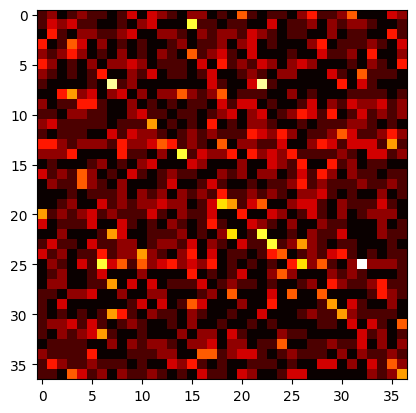

In [40]:
plt.imshow(confusion_matrix(y_pred,y), cmap='hot', interpolation='nearest')
plt.show()

In [41]:
print(f"Accuracy: {np.sum(np.array(y_pred)==np.array(y))/(len(y))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_pred)==np.array(y))/len(y))/(1/37):.2f}")

Accuracy: 7.6%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 2.80


In [ ]:
stop_ray_cluster()